## 1.上传本地数据集，导入相关包
-----
在./work上上传mnist数据集

In [ ]:
# 安装VisualDL
!pip install --upgrade --pre visualdl

In [ ]:
# 导入相关包
import paddle
import numpy as np
import matplotlib.pyplot as plt
import json
import gzip
import os
import random
import paddle.nn.functional as F
from paddle.nn import Conv2D, MaxPool2D, Linear
from PIL import Image
from paddle.static import InputSpec
#引入VisualDL库，并设定保存作图数据的文件位置
from visualdl import LogWriter
log_writer = LogWriter(logdir="./log")

## 2.数据处理
----
对mnisi数据集进行处理并封装成函数形式

In [ ]:
def load_data(mode='train'):
    # 定义数据集路径
    data_file = "/home/aistudio/data/data145337/mnist.json.gz"
    print("loading dataset from {}".format(data_file))
    data = json.load(gzip.open(data_file))
    # 读取数据集中的训练集，验证集和测试集
    train_set, val_set, test_set = data
    # 数据集相关参数
    IMG_ROWS = 28
    IMG_COLS = 28

    # 根据mode参数来选择方式
    if mode == 'train':
        images = train_set[0]
        labels = train_set[1]
    elif mode == 'val':
        images = val_set[0]
        labels = val_set[1]
    elif mode == 'test':
        images = test_set[0]
        labels = test_set[1]

    # 验证图片数量和标签数是否一致
    images_length = len(images)
    assert images_length == len(labels)
    print("length of train_images{} should be the same as labels{}".format(images_length, len(labels)))

    # 定义index_list为处理数据准备
    index_list = list(range(images_length))
    # 定义BATCHSIZE
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        images_list = []
        labels_list = []
        for i in index_list:
            img = np.reshape(images[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('int64')
            images_list.append(img)
            labels_list.append(label)
            # 如果image_list达到一个batchsize则返回一个批次数据
            if len(images_list) == BATCHSIZE:
                yield np.array(images_list), np.array(labels_list)
                # 清空数据列表
                images_list = []
                labels_list = []

        # 如果剩余数量小于100，则返回剩余数据
        if len(images_list) > 0:
            yield np.array(images_list), np.array(labels_list)

    return data_generator


## 3. 定义模型结构
----
通过MNIST类构建模型属性，以及模型方法

In [ ]:
# 定义模型结构
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()

        # 定义卷积层和池化层以及最后的全连接层，输出特征通道为20，卷积核的大小为5，卷积步长为1，padding为2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
        self.fc = Linear(in_features=980, out_features=10)

        # 定义前向计算过程
    @paddle.jit.to_static  # 添加装饰器，使动态图网络结构在静态图模式下运行
    def forward(self, inputs, label):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, [x.shape[0], 980])
        x = self.fc(x)
        if label is not None:
            acc = paddle.metric.accuracy(input=x, label=label)
            return x, acc
        else:
            return x


# 调用load_data函数
train_loader = load_data('train')
# 使用GPU进行训练
# use_gpu = True
# paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')


loading dataset from /home/aistudio/data/data145337/mnist.json.gz
length of train_images50000 should be the same as labels50000


## 4.封装训练函数以及进行模型训练
____
训练之后保存模型结构和参数

In [5]:
# 封装训练函数
def train(model):
    model = MNIST()
    model.train()
    # 使用随机梯度下降SGD优化算法
    opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())

    # 定义迭代轮数
    epoch_num = 5
    iter = 0
    for epoch_id in range(epoch_num):
        # 每训练一轮就保存一轮模型结构
        # paddle.save(model.state_dict(), './mnist.pdparams {}'.format(epoch_id))
        # print('model has been saved in ./mnist.pdparams')
        for batch_id, data in enumerate(train_loader()):
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)

            # 前向计算
            predicts, acc = model(images, labels)
            # 利用交叉熵损失函数计算loss
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)

            # 每训练200批次数据，就打印当前loss情况
            if batch_id % 200 == 0:
                print('epoch: {}, batch: {}, loss is {}, acc is {}'.format(epoch_id, batch_id, avg_loss, acc))
                log_writer.add_scalar(tag = 'acc', step = iter, value = acc.numpy())
                log_writer.add_scalar(tag = 'loss', step = iter, value = avg_loss.numpy())
                iter = iter + 100

            # 后向传播更新参数消除梯度
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    # 保存模型参数
    paddle.save(model.state_dict(), './best_mnist.pdparams')
    print("trained model_params has been saved")
    # 保存inference模型结构，可用于部署
    paddle.jit.save(
    layer=model,
    path="inference/mnist")
    print("==>Inference model saved in inference/mnist.")


# 启动训练
model = MNIST()
train(model)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


epoch: 0, batch: 0, loss is Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [2.68310571]), acc is Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [0.09000000])
epoch: 0, batch: 200, loss is Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [0.05868373]), acc is Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [0.98000002])
epoch: 0, batch: 400, loss is Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [0.03520438]), acc is Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [0.99000001])


KeyboardInterrupt: 

## 5.模型评估
---
使用test测试数据集进行模型评估，计算多个batch的平均损失和准确率

In [ ]:
def evaluation(model):
    print("start evaluation......")
    # 确定模型参数路径
    model_params_path = "best_mnist.pdparams"
    # 加载模型参数
    param_dict = paddle.load(model_params_path)
    model.load_dict(param_dict)
    model.eval()
    test_loader = load_data('test')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(test_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)

        # 前向计算
        predicts, acc = model(images, labels)
        # 利用交叉熵损失函数计算loss
        loss = F.cross_entropy(predicts, labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))

    # 计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation......
loading dataset from /home/aistudio/data/data145337/mnist.json.gz
length of train_images10000 should be the same as labels10000
loss=0.06793506548141522, acc=0.9807000070810318


## 6.可视化分析
----
VisualDL是飞桨可视化分析工具，以丰富的图表呈现训练参数变化趋势、模型结构、数据样本、高维数据分布等。帮助用户清晰直观地理解深度学习模型训练过程及模型结构，进而实现高效的模型调优。以下是可视化图形![](https://ai-studio-static-online.cdn.bcebos.com/f0b9e6317d6e4987a17c3f0587ddaad4c7086526e22146e2b9cc38677685de00)
![](https://ai-studio-static-online.cdn.bcebos.com/f45863b8f45f40538b14777dc1312f44fc84e4ee81a744b99b1b50e1f2ec4a77)


## 7.传入一张手写数字图片进行测试
---
自己动手写一个数字来感受一下模型效果

图像预处理处理以及显示

In [ ]:
# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    # 图像归一化,识别黑底白字不需要归一化处理
    # im = im / 255.0 * 2.0 - 1.0
    return im


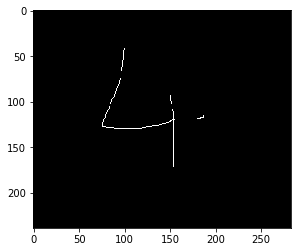

In [ ]:
infer_path='work/t4.png'
img = Image.open(infer_path)
plt.imshow(img)   #根据数组绘制图像
plt.show()        #显示图像

In [ ]:
# 定义预测过程
model = MNIST()
params_file_path = 'best_mnist.pdparams'
img_path = 'work/t4.png'
# 加载模型参数
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
# 灌入数据
model.eval()
im = load_image(img_path)
#模型反馈10个分类标签的对应概率
results = model(paddle.to_tensor(im), label=None)
#取概率最大的标签作为预测输出
lab = np.argsort(results.numpy())
print("本次预测的数字是: ", lab[0][-1])

本次预测的数字是:  4
